# Treinamento e teste

Nesse notebook estão descritos os passos necessários para treinar o modelo na Google AI Platform. A organização dos tópicos é a seguinte:

 **1. Configuração de ambiente**

 **2. Treinamento local**

 **3. Treinamento na núvem**

 **4. Teste**

## 1. Configuração de ambiente

Inicialmente, é necessário definir os parâmetros e importar as bibliotecas necessárias para o treinamento local e na núvem. 

- **BUCKET** : Intervalo (bucket) no Google Storage
- **PROJECT** : Projeto na GCP
- **REGION** : Região da GCP para realizar o treinamento


Importando recursos necessários:

In [1]:
!pip install keras

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl


In [2]:
import time
import os
import json
from utils import add_to_model_list, test_model

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BUCKET = "bi-bbrands-ml"
PROJECT = "bi-bbrands"
REGION = "us-central1"

os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

## 2. Treinamento local

Antes de enviar o modelo para treinamento na núvem, é interessante testá-lo locamente com um volume pequeno de dados, afim de corrigir possíveis erros. O treinamento local requer os seguintes parâmetros:

- **PACKAGE_PATH** : caminho do pacote de treinamento do modelo

- **N_INPUT** : comprimento da sequência de entrada

- **N_OUTPUT** : comprimento da sequência de saída

- **INPUT_COLS** : colunas do dataset a serem utilizadas como input do modelo, sendo a última coluna da lista aquela para a qual se deseja fazer a previsão

- **LAYERS** : número de neurônios por camada que compõe o a rede neural recorrente

- **RNN_CELL_TYPE** : Tipo de célula a ser utilizada na construção da RNN. Possíveis variações: **LSTM**, **GRU**. 

- **BATCH_SIZE** : tamanho do lote de treinamento

- **EPOCHS** : número de épocas de treinamento

- **VALIDATION_FROM_PAST** : campo booleano, cofigura amostragem do dataset de validação no passado do dataset de treino

- **STEPS_PER_EPOCH** : número de passos de treinamento por época (coresponde ao número de lotes lidos por época)

- **VALIDATION_STEPS** : número de passos de validação a serem realizados ao final de cada época

- **DATASET_NAME** : nome do dataset a ser utilizado no treinamento

- **MODEL_NAME** : nome dado ao modelo

- **INPUT_FOLDER** : diretório contendo os datasets de treinamento

- **OUTPUT_FOLDER** : diretório de saída para o modelo treinado

- **LOGS_FOLDER** : diretório de saída para salvar os logs de treinamento do tensorboard

In [3]:
PACKAGE_PATH = './energyforecast/trainer'
INPUT_FOLDER = '/content/datalab/energyforecast/data/sequences/'
OUTPUT_FOLDER = '/content/datalab/energyforecast/local_training/'
LOGS_FOLDER = '/content/datalab/energyforecast/local_training/tensorboard_logs/'
N_INPUT = '60'
N_OUTPUT = '60'
INPUT_COLS = ['dayofyear_t+1', 'weekofyear_t+1', 'day_t+1', 'dayofweek_t+1', 'hour_t+1', 'global_active_power']
LAYERS = ['50', '50']
RNN_CELL_TYPE = 'LSTM'
INPUT_DROPOUT = '0.2'
RECURRENT_DROPOUT = '0.2'
BATCH_SIZE = '500'
EPOCHS = '5'
STEPS_PER_EPOCH = '3'
VALIDATION_STEPS = '2'
VALIDATION_FROM_PAST = False
MODEL_VERSION_NAME = 's2s_basic_localtest'

if VALIDATION_FROM_PAST:
  VALIDATION_SAMPLING_TYPE = 'vp'
else:
  VALIDATION_SAMPLING_TYPE = 'vf'
FILENAME_PATTERN = 'hpc'
DATASET_NAME = '{}_{}_{}x{}_{}'.format(FILENAME_PATTERN,VALIDATION_SAMPLING_TYPE,N_INPUT,N_OUTPUT,BATCH_SIZE)
MODEL_NAME = '{}_{}_{}_id{}_rd{}_{}'.format(MODEL_VERSION_NAME,RNN_CELL_TYPE,'x'.join(LAYERS),INPUT_DROPOUT.replace('.',''),RECURRENT_DROPOUT.replace('.',''),DATASET_NAME)

os.environ['PACKAGE_PATH'] = PACKAGE_PATH
os.environ['N_INPUT'] = N_INPUT
os.environ['N_OUTPUT'] = N_OUTPUT
os.environ['INPUT_COLS'] = ' '.join(INPUT_COLS)
os.environ['LAYERS'] = ' '.join(LAYERS)
os.environ['RNN_CELL_TYPE'] = RNN_CELL_TYPE
os.environ['BATCH_SIZE'] = BATCH_SIZE
os.environ['EPOCHS'] = EPOCHS
os.environ['STEPS_PER_EPOCH'] = STEPS_PER_EPOCH
os.environ['VALIDATION_STEPS'] = VALIDATION_STEPS
os.environ['INPUT_DROPOUT'] = INPUT_DROPOUT
os.environ['RECURRENT_DROPOUT'] = RECURRENT_DROPOUT
os.environ['FILENAME_PATTERN'] = FILENAME_PATTERN
os.environ['DATASET_NAME'] = DATASET_NAME
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['INPUT_FOLDER'] = INPUT_FOLDER
os.environ['OUTPUT_FOLDER'] = OUTPUT_FOLDER
os.environ['LOGS_FOLDER'] = LOGS_FOLDER

print('Model name: {}'.format(MODEL_NAME))

Model name: s2s_basic_localtest_LSTM_50x50_id02_rd02_hpc_vf_60x60_500


In [19]:
%bash
gcloud ml-engine local train \
--module-name=trainer.task \
--package-path=${PACKAGE_PATH} \
-- \
--output_dir=${OUTPUT_FOLDER} \
--logs_dir=${LOGS_FOLDER} \
--train_data_path=${INPUT_FOLDER}${DATASET_NAME}/ \
--eval_data_path=${INPUT_FOLDER}${DATASET_NAME}/ \
--epochs=${EPOCHS} \
--steps_per_epoch=${STEPS_PER_EPOCH} \
--validation_steps=${VALIDATION_STEPS} \
--input_sequence_length=${N_INPUT} \
--target_sequence_length=${N_OUTPUT} \
--input_columns ${INPUT_COLS} \
--layers ${LAYERS} \
--rnn_cell_type=${RNN_CELL_TYPE} \
--filename_pattern=${FILENAME_PATTERN} \
--recurrent_dropout=${RECURRENT_DROPOUT} \
--input_dropout=${INPUT_DROPOUT} \
--model_name=${MODEL_NAME}

Started training and evaluation
Instantiating the model...
{'train_data_path': '/content/datalab/energyforecast/data/sequences/hpc_vf_60x60_500/', 'layers': [50, 50], 'eval_data_path': '/content/datalab/energyforecast/data/sequences/hpc_vf_60x60_500/', 'decay': 0, 'steps_per_epoch': '3', 'epochs': '5', 'input_sequence_length': 60, 'input_dropout': '0.2', 'input_columns': ['dayofyear_t+1', 'weekofyear_t+1', 'day_t+1', 'dayofweek_t+1', 'hour_t+1', 'global_active_power'], 'model_name': 's2s_basic_localtest_LSTM_50x50_id02_rd02_hpc_vf_60x60_500', 'recurrent_dropout': '0.2', 'target_sequence_length': 60, 'rnn_cell_type': 'LSTM', 'train_batch_size': 200, 'num_input_features': 1, 'learning_rate': 0.01, 'logs_dir': '/content/datalab/energyforecast/local_training/tensorboard_logs/', 'validation_steps': '2', 'filename_pattern': 'hpc'}
Starting model building...
Model Compiled
__________________________________________________________________________________________________
Layer (type)          

2019-06-18 13:01:48.726988: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/network.py:877: UserWarning: Layer rnn_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn_1/while/Exit_2:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'rnn_1/while/Exit_3:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'rnn_1/while/Exit_4:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'rnn_1/while/Exit_5:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and 

## 3. Treinamento na núvem

### 3.1 Instanciando um job de treinamento

Após executar o teste local do treinamento do modelo, vamos treiná-lo na núvem, utilizando todo o volume de dados. Inicialmente, é necessário definiar os parâmetros de treinamento:

In [44]:
# Parêtros configuráveis
PACKAGE_PATH = './energyforecast/trainer'
N_INPUT = '60'
N_OUTPUT = '60'
BATCH_SIZE = '500'
LAYERS = ['50','50']
RNN_CELL_TYPE = 'LSTM'
EPOCHS = '70'
VALIDATION_FROM_PAST = False
INPUT_DROPOUT = '0.3'
RECURRENT_DROPOUT = '0.3'
FILENAME_PATTERN = 'MAC005269_h'
MODEL_VERSION_NAME = 's2s_basic_nomultiproc_{}_epochs'.format(EPOCHS)
INPUT_COLS = ['dayofyear_t+1', 'weekofyear_t+1', 'day_t+1', 'dayofweek_t+1', 'hour_t+1', 'global_active_power']

In [45]:
ts = time.gmtime()

# Parâmetros automáticos
if VALIDATION_FROM_PAST:
  VALIDATION_SAMPLING_TYPE = 'vp'
else:
  VALIDATION_SAMPLING_TYPE = 'vf'
DATASET_NAME = '{}_{}_{}x{}_{}'.format(FILENAME_PATTERN,VALIDATION_SAMPLING_TYPE,N_INPUT,N_OUTPUT,BATCH_SIZE)
DATASET_LIST_PATH = './data/dataset_list.json'
MODEL_LIST_PATH = './models/s2s/model_list.json'

# Obter informações do dataset
with open(DATASET_LIST_PATH, 'r') as f:
    dataset_list = json.load(f)
    STEPS_PER_EPOCH = dataset_list[DATASET_NAME]['train_batches']
    VALIDATION_STEPS = dataset_list[DATASET_NAME]['valid_batches']
    
# Configuração do job de treinamento
MODEL_NAME = '{}_{}_{}_id{}_rd{}_{}'.format(MODEL_VERSION_NAME,RNN_CELL_TYPE,'x'.join(LAYERS),INPUT_DROPOUT.replace('.',''),RECURRENT_DROPOUT.replace('.',''),DATASET_NAME)
JOB_NAME = '{}_{}'.format(MODEL_NAME, time.strftime("%Y_%m_%d_%H_%M_%S", ts))
INPUT_FOLDER = 'gs://{}/data/sequences/{}/'.format(BUCKET,DATASET_NAME)
OUTPUT_FOLDER = 'gs://{}/s2s/'.format(BUCKET)
LOGS_FOLDER = 'gs://{}/s2s/tensorboard_logs/'.format(BUCKET)

# Salvando metadados de treinamento
model_metadata = {}
model_metadata['model_name'] = MODEL_NAME
model_metadata['job_name'] = JOB_NAME
model_metadata['dataset_name'] = DATASET_NAME
model_metadata['input_cols'] = INPUT_COLS
add_to_model_list(model_metadata,MODEL_LIST_PATH)

# Configurando variáveis de ambiente
os.environ['PACKAGE_PATH'] = PACKAGE_PATH
os.environ['N_INPUT'] = N_INPUT
os.environ['N_OUTPUT'] = N_OUTPUT
os.environ['INPUT_COLS'] = ' '.join(INPUT_COLS)
os.environ['LAYERS'] = ' '.join(LAYERS)
os.environ['RNN_CELL_TYPE'] = RNN_CELL_TYPE
os.environ['BATCH_SIZE'] = BATCH_SIZE
os.environ['EPOCHS'] = EPOCHS
os.environ['STEPS_PER_EPOCH'] = STEPS_PER_EPOCH
os.environ['VALIDATION_STEPS'] = VALIDATION_STEPS
os.environ['INPUT_DROPOUT'] = INPUT_DROPOUT
os.environ['RECURRENT_DROPOUT'] = RECURRENT_DROPOUT
os.environ['FILENAME_PATTERN'] = FILENAME_PATTERN
os.environ['DATASET_NAME'] = DATASET_NAME
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['INPUT_FOLDER'] = INPUT_FOLDER
os.environ['OUTPUT_FOLDER'] = OUTPUT_FOLDER
os.environ['LOGS_FOLDER'] = LOGS_FOLDER
os.environ['JOB_NAME'] = JOB_NAME

O comando abaixo cria um job de treinamento na Google AI Platform segundo os parâmetros definidos anteriormente.

In [46]:
%bash
gcloud ml-engine jobs submit training ${JOB_NAME} \
--module-name=trainer.task \
--package-path=${PACKAGE_PATH} \
--region=${REGION} \
--config=${PACKAGE_PATH}/cloudml-gpu.yaml \
--job-dir=${OUTPUT_FOLDER} \
-- \
--output_dir=${OUTPUT_FOLDER} \
--logs_dir=${LOGS_FOLDER} \
--train_data_path=${INPUT_FOLDER} \
--eval_data_path=${INPUT_FOLDER} \
--epochs=${EPOCHS} \
--steps_per_epoch=${STEPS_PER_EPOCH} \
--validation_steps=${VALIDATION_STEPS} \
--input_sequence_length=${N_INPUT} \
--target_sequence_length=${N_OUTPUT} \
--input_columns ${INPUT_COLS} \
--layers ${LAYERS} \
--rnn_cell_type=${RNN_CELL_TYPE} \
--filename_pattern=${FILENAME_PATTERN} \
--recurrent_dropout=${RECURRENT_DROPOUT} \
--input_dropout=${INPUT_DROPOUT} \
--model_name=${MODEL_NAME}

jobId: s2s_basic_nomultiproc_70_epochs_LSTM_50x50_id03_rd03_MAC005269_h_vf_60x60_500_2019_06_23_18_59_51
state: QUEUED


Job [s2s_basic_nomultiproc_70_epochs_LSTM_50x50_id03_rd03_MAC005269_h_vf_60x60_500_2019_06_23_18_59_51] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe s2s_basic_nomultiproc_70_epochs_LSTM_50x50_id03_rd03_MAC005269_h_vf_60x60_500_2019_06_23_18_59_51

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs s2s_basic_nomultiproc_70_epochs_LSTM_50x50_id03_rd03_MAC005269_h_vf_60x60_500_2019_06_23_18_59_51


### 3.2 Monitorando o treinamento com o TensorBoard

O comportamento das métricas do modelo durante o treinamento são extremamente importantes, pois permitem a identificação de problemas de *overfitting* e de convergência. O seu monitoramento pode ser realizado através do TensorBoard, uma ferramenta do TensorFlow que permite o monitoramento e a documentação das sessões de treinamento de maneira simples. O TensorBoard pode ser configurado a partir de um *callback*, que será chamado pelo modelo durante o treinamento. Os registros são salvos na pasta definida em **LOGS_FOLDER** na etapa anterior. Para acessar os dados de treinamento, é necessário iniciar uma instância do TensorBoard, passando como parâmetro o caminho dos registros.

In [4]:
from google.datalab.ml import TensorBoard
LOGS_FOLDER = 'gs://{}/s2s/tensorboard_logs/'.format(BUCKET)
TensorBoard().start(LOGS_FOLDER)

TensorBoard was started successfully with pid 3750. Click here to access it.

3750

Após a consulta dos dados de treinamento, o TensorBoard pode ser finalizado como segue:

In [11]:
for pid in TensorBoard.list()["pid"]:
    TensorBoard().stop(pid)
    print("Stopped TensorBoard with pid {}".format(pid))

Stopped TensorBoard with pid 5533


## 4. Teste

Após finalizar o treinamento, modelo deve ser testado em dados desconhecidos a fim de avaliar seu comportamento em condições de operação reais. Os modelos treinados são salvos no destino definido anteriormente em **OUTPUT_FOLDER**, sendo que para cada sessão de treinamento, dois arquivos são salvos: o modelo ao final de todas as épocas de treinamento e um modelo *checkpoint*, que contém a versão que obteve o melhor desempenho no dataset de validação ao longo de todas as épocas. Como o intuíto é obter o melhor resultado possível, vamos usar o modelo *checkpoint* durante o teste do modelo.

### 4.1 Dowload dos dados de treinamento

Os registros de treinamento e os modelos treinados são salvos no Google Storage, portanto, incialmente será feito o downlaod dos arquivos para uma pasta local:

In [5]:
OUTPUT_FOLDER = 'gs://{}/s2s/'.format(BUCKET)
os.environ['OUTPUT_FOLDER'] = OUTPUT_FOLDER

In [6]:
%bash
gsutil -m cp -r ${OUTPUT_FOLDER}trained_models ./models/s2s
#gsutil -m cp -r ${OUTPUT_FOLDER}tensorboard_logs ./models/s2s

Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_70_epochs_LSTM_100x100_id03_rd03_hpc_h_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_60_epochs_LSTM_20x20_id03_rd03_hpc_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_70_epochs_LSTM_100_id03_rd03_hpc_h_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_60_epochs_LSTM_20x20x20_id03_rd03_hpc_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_60_epochs_LSTM_50x50_id03_rd03_hpc_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_70_epochs_LSTM_10_id03_rd03_hpc_h_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_70_epochs_LSTM_10x10_id03_rd03_hpc_h_vf_60x60_500.h5...
Copying gs://bi-bbrands-ml/s2s/trained_models/checkpoint_s2s_

### 4.2 Configuração do Teste

In [7]:
# Parêtros configuráveis
N_INPUT = '60'
N_OUTPUT = '60'
BATCH_SIZE = '500'
LAYERS = ['50','50']
RNN_CELL_TYPE = 'LSTM'
FILENAME_PATTERN = 'hpc_m'
MODEL_VERSION_NAME = 's2s_basic_nomultiproc_70_epochs'
VALIDATION_FROM_PAST = False
INPUT_DROPOUT = '0.3'
RECURRENT_DROPOUT = '0.3'
LOAD_CHECKPOINT_MODEL = True
LOGS_FOLDER = './models/s2s/tensorboard_logs/'
TRAINED_MODELS_FOLDER = './models/s2s/trained_models/'
INPUT_FOLDER = './data/sequences/'

In [8]:
# Parâmetros automáticos
if VALIDATION_FROM_PAST:
  VALIDATION_SAMPLING_TYPE = 'vp'
else:
  VALIDATION_SAMPLING_TYPE = 'vf'
DATASET_NAME = '{}_{}_{}x{}_{}'.format(FILENAME_PATTERN,VALIDATION_SAMPLING_TYPE,N_INPUT,N_OUTPUT,BATCH_SIZE)
MODEL_NAME = '{}_{}_{}_id{}_rd{}_{}'.format(MODEL_VERSION_NAME,RNN_CELL_TYPE,'x'.join(LAYERS),INPUT_DROPOUT.replace('.',''),RECURRENT_DROPOUT.replace('.',''),DATASET_NAME)
DATASET_LIST_PATH = './data/dataset_list.json'
MODEL_LIST_PATH = './models/s2s/model_list.json'
DATASET_PATH = INPUT_FOLDER + DATASET_NAME + '/'

A função abaixo realiza o teste do modelo, avaliando seus resultados para diferentes porções do dataset de teste. Para maiores informações, consulte o arquivo **./utils.py**.

In [9]:
results = test_model(dataset_path=DATASET_PATH,
                     dataset_list_path=DATASET_LIST_PATH,
                     dataset_name=DATASET_NAME,
                     model_list_path=MODEL_LIST_PATH,
                     model_name=MODEL_NAME,
                     n_input=int(N_INPUT),
                     n_output=int(N_OUTPUT),
                     filename_pattern=FILENAME_PATTERN,
                     trained_models_folder=TRAINED_MODELS_FOLDER,
                     load_checkpoint_model=LOAD_CHECKPOINT_MODEL, run_mode='test')

print('Average loss: {}'.format(results['avg_loss']))
print('Average loss on first batch : {}'.format(results['avg_loss_first_batch']))

Loading the trained model at ./models/s2s/trained_models/checkpoint_s2s_basic_nomultiproc_70_epochs_LSTM_50x50_id03_rd03_hpc_m_vf_60x60_500.h5...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 6)      0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 5)      0                                            
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, 50), (None,  31600       encoder_inputs[0][0]             
__________________________________________________________________________________________________
rnn_2 (RNN)                     [(None, None, 50), ( 31400    

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


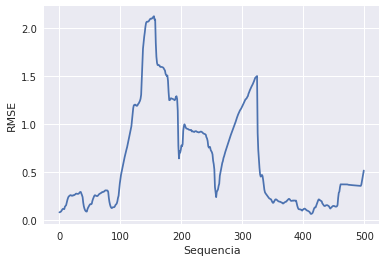

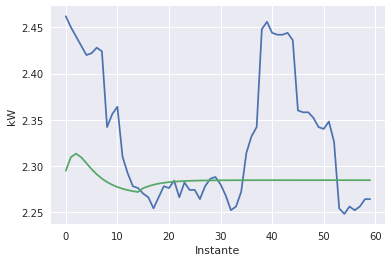

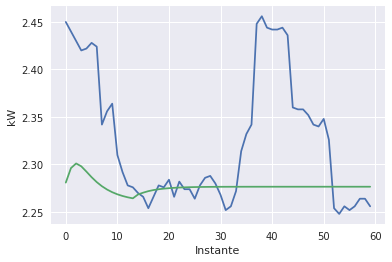

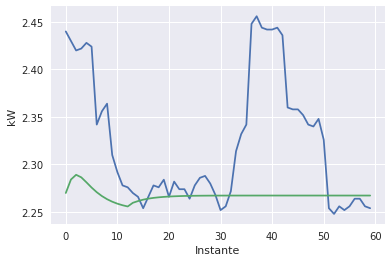

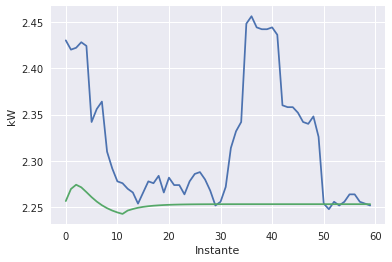

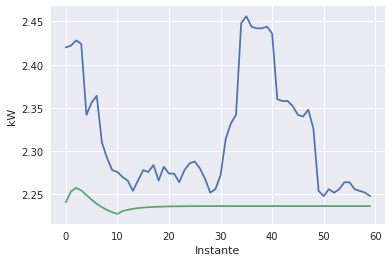

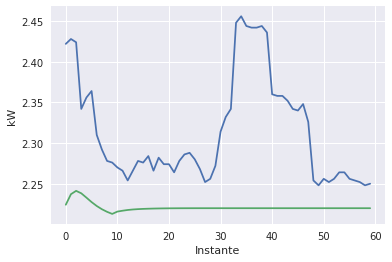

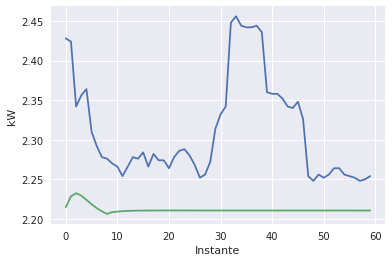

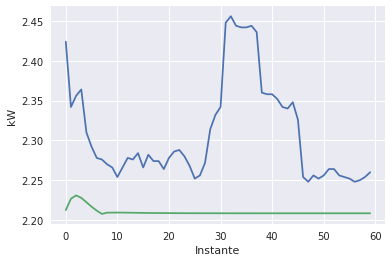

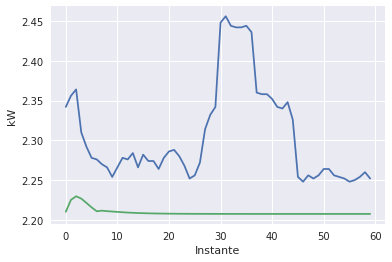

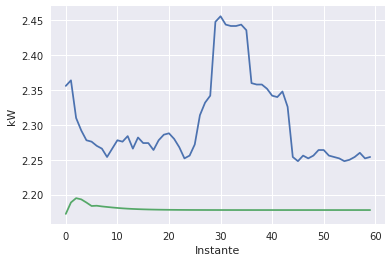

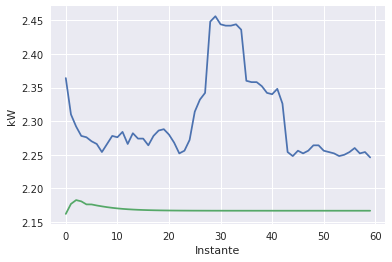

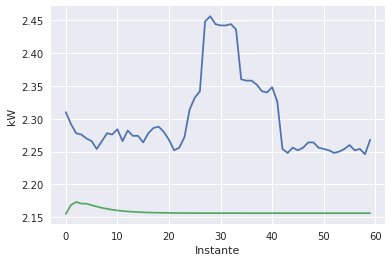

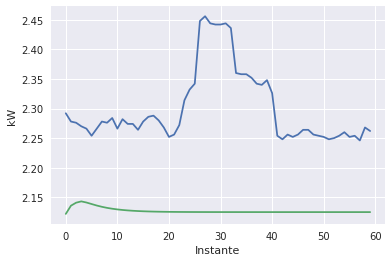

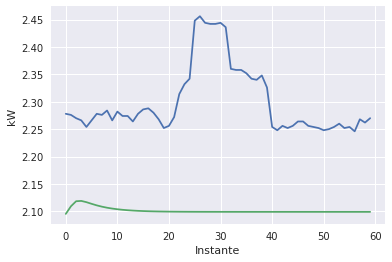

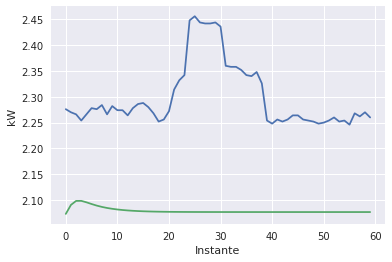

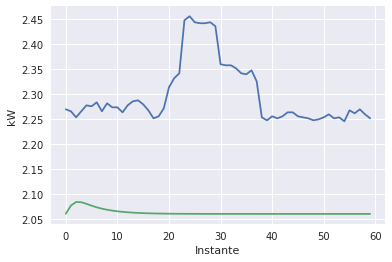

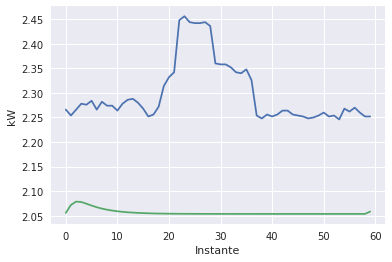

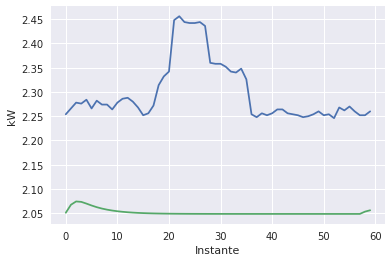

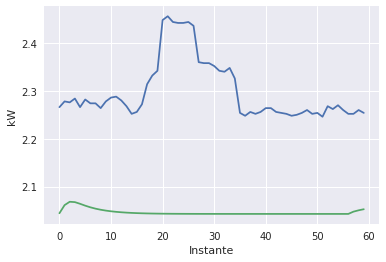

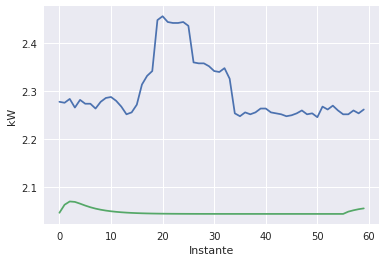

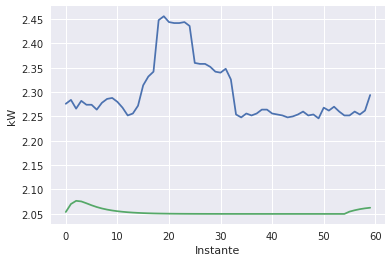

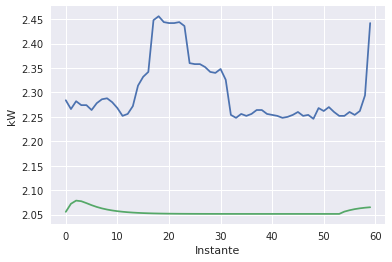

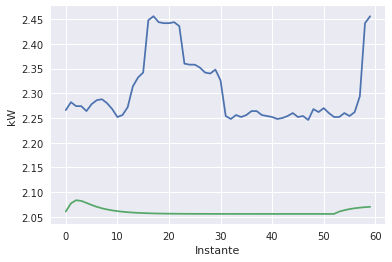

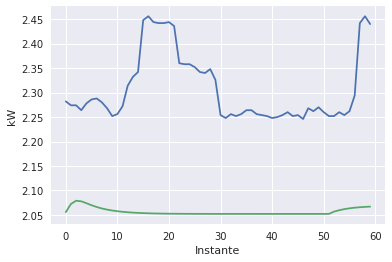

In [10]:
import matplotlib.pyplot as plt

sample = 1

plt.plot(results['loss_vec_first_batch'])
plt.ylabel('RMSE')
plt.xlabel('Sequencia')
plt.show()
for sample in range(24):
  y = results['Y_first_batch'][sample]
  y_hat = results['Y_hat_first_batch'][sample]
  plt.plot(y)
  plt.plot(y_hat)
  plt.ylabel('kW')
  plt.xlabel('Instante')
  plt.show()

In [26]:
def get_split_arr(dataset_split,batch_number):
  import numpy as np
  dataset_split = np.array(dataset_split)
  split_arr = np.floor(dataset_split*batch_number)

  if split_arr[1] == 0:
    split_arr[1] = 1
  
  split_arr[2] = batch_number - split_arr[0] - split_arr[1]
  
  if split_arr[2] == 0:
    split_arr[2] = 1
    split_arr[0] = split_arr[0] - 1 
  split_arr = split_arr.astype(int)

  if split_arr[0] == 0:
    raise Exception('The split vector produces 0 batches for train dataset!')
  elif split_arr[1] == 0:
    raise Exception('The split vector produces 0 batches for valid dataset!')
  elif split_arr[2] == 0:
    raise Exception('The split vector produces 0 batches for test dataset!')
  
  return split_arr

In [65]:
get_split_arr([0.90,0.07,0.03],72)

array([64,  5,  3])

In [127]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}

matplotlib.rc('font', **font)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(x1, y1)
ax.set_xlabel('time [s]', fontsize='large', fontweight='bold')
ax.set_ylabel('Damped oscillation [V]', fontproperties=font)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


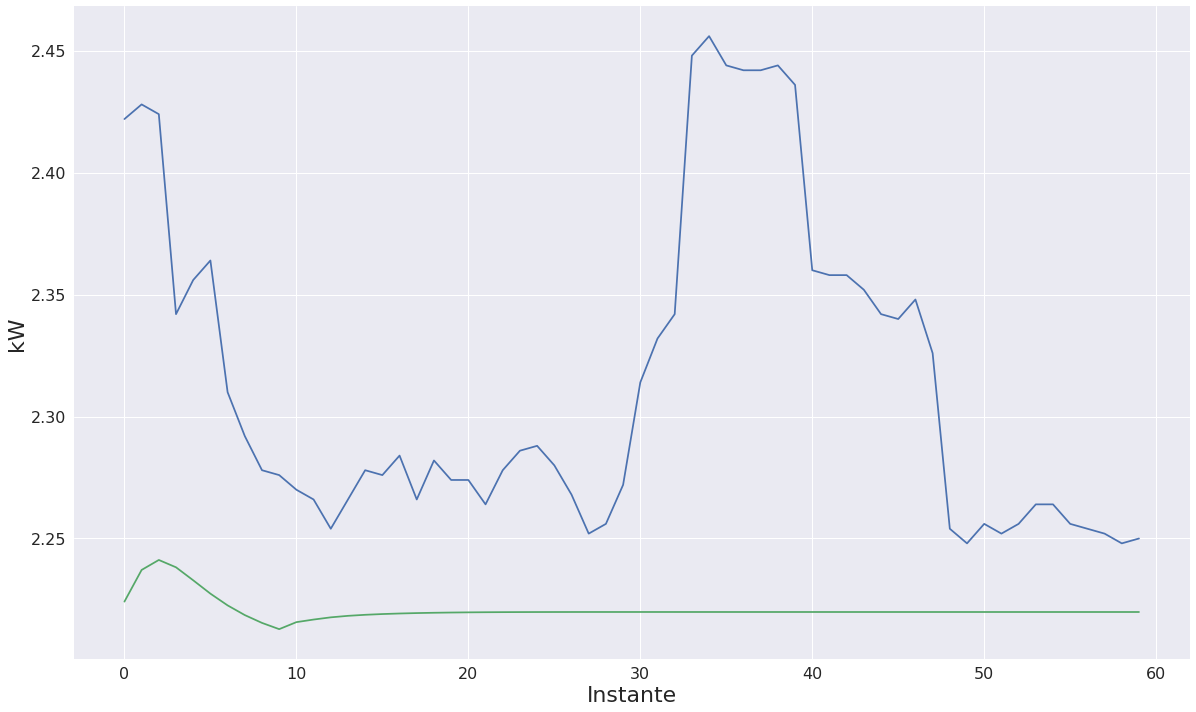

In [12]:
sample = 5
y = results['Y_first_batch'][sample]
y_hat = results['Y_hat_first_batch'][sample]
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.figure(figsize=(20,12))
plt.plot(y)
plt.plot(y_hat)
plt.ylabel('kW', fontsize=22)
plt.xlabel('Instante', fontsize=22)

plt.show()